In [ ]:
import os
import numpy as np
import pandas as pd
import pylab as plt

import scipy.integrate
import scipy.io

#import winsound

In [ ]:
directory = os.getcwd()

est_params = pd.read_csv("./p53_parameters_summaryTable.txt", sep=' ', decimal = ".", index_col = False)
est_params = est_params.set_index('objFun')

In [ ]:
# Dosage
DDR         = 1

# =========================
# Fixed parameters
# =========================
hcmdm21     = 2
hcwip11     = 2       # could be critical for getting quick peak dynamics for MCF7

# ksp210     = 0.00765773
# ksp211     = 0.788386
# jsp211     = 0.124622
# hcp211     = 2
# kshipk2    = [0.1, 1]        # 0.0659213
# kdp53      = [2, 8]          # T1/2 = 5–20 min; 1.3863 -> half-life 30min -> 1.3
# kdp53a     = [0.1, 0.2]      # half-life 4h -> 0.17, 200min -> 0.2
# kdp53k     = [0.1, 0.2]      # 0.0132642

kdhipk2     = 1.5     # HIPK2 protein degradation basal; T1/2 ~27min; stress-induced >240min depending on regulation
kdp53m      = 0.077   # p53 mRNA half-life ~9h
kdwip1m     = 0.66    # WIP1 mRNA degradation (T1/2 ~1h); doi.org/10.1016/j.cels.2016.03.006
kdwip1      = 2       # WIP1 protein degradation (T1/2 20–60min); doi:10.1016/j.molcel.2013.06.010, 10.1083/jcb.201210031
kdmdm2m     = 0.7     # MDM2 mRNA degradation; short T1/2 <1h
kdmdm2      = 2       # MDM2 protein degradation; T1/2 ~20min

# kdp21m     = 1.39    # 0.620255
# kdbaxm     = 0.35    # 1.40314
# jup53      = [0.01, 0.1]      # 0.05 MDM2_0=0.18 MCF7 data
# jup53s     = [0.1, 1]         # 0.5

kuhipk2     = 0.17    # HIPK2 protein degradation, SIAH1 induced; T1/2 ~240min
# juhipk2    = [0.001, 1]       # 0.5

# ksbax0     = 0.225133
# ksbax1     = 0.439204
# jsbax1     = 0.00753637
# hcbax1     = 2

hcdeg       = 2
kalg        = 0.1     # 0.109211


# =========================
# Fixed Initial Conditions
# =========================
p_p53i_0        = 0.1     # from WB DR SY5Y
p_p53i_0_MCF7   = 0.056   # from WB TC MCF7
p_MDM2m_0_MCF7  = 0.18    # from MCF7 data at t=0
p_MDM2m_0       = 0.103   # 0.18 / 1.75 because MDM2m is 1.75x higher in MCF7
p_p53m_0        = 0.1
p_p53m_0_MCF7   = 0.29    # 2.9-fold change in expression

WIP1m_0_MCF7    = 0.30    # from MCF7 data
WIP1_0_MCF7     = 0.14    # from MCF7 data
WIP1m_0         = 0.0594  # WIP1 5.05x higher in MCF7
WIP1_0          = 0.0277

MDM2_0          = 1
MDM2_0_MCF7     = 1.75


# =========================
# Other Initial Conditions
# =========================
p_ATM_0         = 1
p_SIAH_0        = 1
p_HIPK2_0       = 0.018
p_CHK2          = 1
icZero          = 0
# p21m_0        = 0.1068
# BAXm_0        = 0.3


# =========================
# Estimated Parameters
# =========================
# loaded from bestFits file into param_est, param_id
i_selectedrun   = 0
# for i_init_pest = 1:length(param_id)
#   (param_id{i_init_pest}) = param_est(i_selectedrun, i_init_pest)
# end


# =========================
# Parameters fixed through algebraic constraints for IC
# =========================
# -- p53 mRNA --
ksp530     = p_p53m_0 * kdp53m   # rate of basal p53 mRNA expression determined by IC and kdeg

# -- MDM2 and p53 --
kpsmdm2    = MDM2_0 * kdmdm2 / p_MDM2m_0
h_MDM2_0   = (MDM2_0**hcdeg) / (MDM2_0**hcdeg + est_params.iloc[i_selectedrun]['jup53']**hcdeg)
kpsp53     = est_params.iloc[i_selectedrun]['kdp53'] * p_p53i_0 / p_p53m_0 * h_MDM2_0
h_p53i_0   = ((kalg * p_p53i_0)**hcmdm21) / (est_params.iloc[i_selectedrun]['jsmdm21']**hcmdm21 + (kalg * p_p53i_0)**hcmdm21)
ksmdm20    = kdmdm2m * p_MDM2m_0 - est_params.iloc[i_selectedrun]['ksmdm21'] * h_p53i_0

# -- WIP1 --
kswip10    = kdwip1m * WIP1m_0
kpswip1    = kdwip1 * WIP1_0 / WIP1m_0

# -- HIPK2 --
p_kshipk2  = kdhipk2 * p_HIPK2_0 + kuhipk2 * p_SIAH_0 * (p_HIPK2_0) / (est_params.iloc[i_selectedrun]['juhipk2'] + p_HIPK2_0)

# -- p21 and BAX --
# ksp210   = kdp21m * p21m_0
# ksbax0   = kdbaxm * BAXm_0


# =========================
# Initial Condition Vector
# =========================
x0 = [
    p_ATM_0, icZero, p_p53m_0, p_p53i_0, icZero, icZero,
    p_SIAH_0, icZero, p_HIPK2_0, WIP1m_0, WIP1_0, p_CHK2,
    icZero, p_MDM2m_0, MDM2_0
]   # + [p21m_0, BAXm_0] if enabled


# =========================
# Load Additional Parameters
# =========================
NB_params = pd.read_csv('./nb_params_full_2.csv')
NB_params

,CellLine_ID,HIPK2,WSB1,MDM2,TP53,ATM,PPM1D,CHEK2,SIAH1
0,ACH-001113,4.509898,5.997769,5.334618,4.876900,4.883005,3.529846,4.448273,5.375922
1,ACH-001289,2.065041,5.809942,6.187281,5.044892,4.748016,5.813933,4.727539,4.416961
2,ACH-001339,1.444582,6.093334,4.927721,5.928032,5.119377,3.131790,5.053003,4.101457
3,ACH-001979,6.234407,5.550999,6.135646,5.190481,5.570581,3.597293,2.968881,4.676561
4,ACH-002438,4.586435,4.967888,5.633016,5.537262,4.391025,3.602908,3.894042,4.738860
...,...,...,...,...,...,...,...,...,...
1679,ACH-002996,3.117723,5.498312,4.547512,5.768952,4.842270,3.485453,4.204915,4.665279
1680,ACH-003142,3.418228,6.899828,5.646114,6.889364,5.207397,3.710966,4.012363,4.414061
1681,ACH-000323,3.681224,6.760287,4.050650,5.055803,5.501461,2.595730,3.813381,3.790397
1682,ACH-000830,3.765588,7.804421,5.970463,6.944121,5.485559,4.924689,5.525007,5.297111


In [ ]:
def setpatientparams(i_patientselected):
    """
    Calculate patient-specific parameters and update global variables.
    """

    # -------------------------
    # Global variables to update
    # -------------------------
    global kpsmdm2, kpsp53, kpswip1, x0, kshipk2, kswip10, ksmdm20, ksp530

    # ==================================================
    # Parameters fixed through algebraic constraints (IC)
    # ==================================================
    # -- p53 mRNA --
    ksp530   = p_p53m_0 * kdp53m

    # -- MDM2 and p53 --
    kpsmdm2  = MDM2_0 * kdmdm2 / p_MDM2m_0
    h_MDM2_0 = (MDM2_0**hcdeg) / (MDM2_0**hcdeg + est_params.iloc[i_selectedrun]['jup53']**hcdeg)
    kpsp53   = est_params.iloc[i_selectedrun]['kdp53'] * p_p53i_0 / p_p53m_0 * h_MDM2_0
    h_p53i_0 = ((kalg * p_p53i_0)**hcmdm21) / (est_params.iloc[i_selectedrun]['jsmdm21']**hcmdm21 + (kalg * p_p53i_0)**hcmdm21)
    ksmdm20  = kdmdm2m * p_MDM2m_0 - est_params.iloc[i_selectedrun]['ksmdm21'] * h_p53i_0

    # -- WIP1 --
    kswip10  = kdwip1m * WIP1m_0
    kpswip1  = kdwip1 * WIP1_0 / WIP1m_0

    # -- HIPK2 --
    kshipk2  = kdhipk2 * p_HIPK2_0 + kuhipk2 * p_SIAH_0 * p_HIPK2_0 / (est_params.iloc[i_selectedrun]['juhipk2'] + p_HIPK2_0)

    # -- p21 and BAX (not personalised) --
    # ksp210 = kdp21m * p21m_0
    # ksbax0 = kdbaxm * BAXm_0


    # ==================================================
    # Patient-specific parameters
    # ==================================================
    # -- ATM & CHK2 --
    ATM_0  = NB_params.loc[i_patientselected, 'ATM']   * p_ATM_0
    CHK2_0 = NB_params.loc[i_patientselected, 'CHEK2'] * p_CHK2

    # -- p53 --
    p53m   = NB_params.loc[i_patientselected, 'TP53']  * p_p53m_0
    ksp530 = p53m * kdp53m
    MDM2m  = NB_params.loc[i_patientselected, 'MDM2']  * p_MDM2m_0
    MDM2   = MDM2m * kpsmdm2 / kdmdm2

    h_MDM2 = (MDM2**hcdeg) / (MDM2**hcdeg + est_params.iloc[i_selectedrun]['jup53']**hcdeg)
    p53i   = p53m * kpsp53 / est_params.iloc[i_selectedrun]['kdp53'] / h_MDM2

    h_p53i = ((kalg * p53i)**hcmdm21) / (est_params.iloc[i_selectedrun]['jsmdm21']**hcmdm21 + (kalg * p53i)**hcmdm21)
    ksmdm20 = MDM2m * kdmdm2m - est_params.iloc[i_selectedrun]['ksmdm21'] * h_p53i

    # -- WIP1 --
    WIP1m  = NB_params.loc[i_patientselected, 'PPM1D'] * WIP1m_0
    kswip10 = WIP1m * kdwip1m
    WIP1    = WIP1m * kpswip1 / kdwip1

    # -- SIAH1 --
    SIAH_0 = 0.5 * (NB_params.loc[i_patientselected, 'SIAH1'] +
                    NB_params.loc[i_patientselected, 'WSB1']) * p_SIAH_0

    # -- HIPK2 steady-state solution (positive root) --
    kshipk2 = NB_params.loc[i_patientselected, 'HIPK2'] * p_kshipk2
    HIPK2   = (kshipk2 - SIAH_0 * kuhipk2 - est_params.iloc[i_selectedrun]['juhipk2'] * kdhipk2 +
               (SIAH_0**2 * kuhipk2**2 +
                2 * SIAH_0 * est_params.iloc[i_selectedrun]['juhipk2'] * kdhipk2 * kuhipk2 -
                2 * SIAH_0 * kshipk2 * kuhipk2 +
                est_params.iloc[i_selectedrun]['juhipk2']**2 * kdhipk2**2 +
                2 * est_params.iloc[i_selectedrun]['juhipk2'] * kdhipk2 * kshipk2 +
                kshipk2**2) ** 0.5) / (2 * kdhipk2)

    # -- Sanity checks --
    if ksmdm20 < 0:
        print("Found negative patient-specific value for ksmdm20")
        ksmdm20 = 1e-9

    if HIPK2 < 0:
        print("Found negative patient-specific value for HIPK2")
        HIPK2 = 1e-9


    # ==================================================
    # Initial condition vector
    # ==================================================
    x0 = [
        ATM_0, icZero, p_p53m_0, p_p53i_0, icZero, icZero,
        SIAH_0, icZero, p_HIPK2_0, WIP1m_0, WIP1_0, p_CHK2,
        icZero, p_MDM2m_0, MDM2_0
    ]   # + [p21m_0, BAXm_0] if enabled

In [ ]:
# ============================================
# ODE function
# ============================================

def f(x, t):
    """
    Right-hand side of the p53 network ODEs.

    States (x):
        0  ATM        8  HIPK2       12 CHK2p
        1  ATMp       9  WIP1m       13 MDM2m
        2  p53m       10 WIP1        14 MDM2
        3  p53i       11 CHK2
        4  p53s15
        5  p53s46
        6  SIAH1
        7  SIAH1p
    """

    # -----------------------------
    # Model switches / inputs
    # -----------------------------
    # SY5Y model: WIP1a = const. (=1); MCF7: WIP1a = alpha * WIP1
    WIP1a  = 1
    ku     = np.heaviside(t, 1.0)   # input (step at t >= 0)

    # ATM (damage signal) params
    kpatm  = est_params.iloc[i_selectedrun]['kpatm_dox']
    jpatm  = est_params.iloc[i_selectedrun]['jpatm_dox']
    kdpatm = est_params.iloc[i_selectedrun]['kdpatm_dox']
    jdpatm = est_params.iloc[i_selectedrun]['jdpatm_dox']

    # -----------------------------
    # Unpack states
    # -----------------------------
    ATM,  ATMp,  p53m,  p53i,  p53s15, p53s46, \
    SIAH1, SIAH1p, HIPK2, WIP1m, WIP1, CHK2, CHK2p, \
    MDM2m, MDM2 = x

    # -----------------------------
    # Phosphorylation / dephosphorylation
    # -----------------------------
    v1  = kpatm * ATM  * DDR * ku / (jpatm + ATM)
    v2  = kdpatm * WIP1a * ATMp / (jdpatm + ATMp)
    v3  = est_params.iloc[i_selectedrun]['kpchk2']   * ATMp * CHK2   / (est_params.iloc[i_selectedrun]['jpchk2']   + CHK2)
    v4  = est_params.iloc[i_selectedrun]['kdpchk2']  * WIP1 * CHK2p  / (est_params.iloc[i_selectedrun]['jdpchk2']  + CHK2p)
    v5  = est_params.iloc[i_selectedrun]['kpp53_CHK2'] * CHK2p * p53i / (est_params.iloc[i_selectedrun]['jpp53_CHK2'] + p53i)
    v6  = est_params.iloc[i_selectedrun]['kpp53_ATM']  * ATMp  * p53i / (est_params.iloc[i_selectedrun]['jpp53_ATM']  + p53i)
    v7  = est_params.iloc[i_selectedrun]['kdpp53a']   * WIP1  * p53s15 / (est_params.iloc[i_selectedrun]['jdpp53a']  + p53s15)
    v8  = est_params.iloc[i_selectedrun]['kpp53a']    * HIPK2 * p53s15 / (est_params.iloc[i_selectedrun]['jpp53a']   + p53s15)
    v9  = est_params.iloc[i_selectedrun]['kdpp53k']   * p53s46        / (est_params.iloc[i_selectedrun]['jdpp53k']   + p53s46)
    v10 = est_params.iloc[i_selectedrun]['kpsiah1']   * ATMp  * SIAH1  / (est_params.iloc[i_selectedrun]['jpsiah1']  + SIAH1)
    v11 = est_params.iloc[i_selectedrun]['kdpsiah1']  * SIAH1p        / (est_params.iloc[i_selectedrun]['jdpsiah1'] + SIAH1p)

    # -----------------------------
    # Gene expression (mRNA synthesis)
    # -----------------------------
    # p53 activity proxy and s15 total
    p53alg    = kalg * p53i + p53s15 + p53s46
    p53s15tot = p53s15 + p53s46

    v12 = ksp530
    v13 = ksmdm20
    v14 = est_params.iloc[i_selectedrun]['ksmdm21'] * (p53alg**hcmdm21)   / (est_params.iloc[i_selectedrun]['jsmdm21']**hcmdm21 + p53alg**hcmdm21)
    v15 = kswip10
    v16 = est_params.iloc[i_selectedrun]['kswip11'] * (p53s15tot**hcwip11) / (est_params.iloc[i_selectedrun]['jswip11']**hcwip11 + p53s15tot**hcwip11)
    # v17 = ksp210
    # v18 = ksp211 * (p53s15**hcp211) / (jsp211**hcp211 + p53s15**hcp211)
    # v19 = ksbax0
    # v20 = ksbax1 * (p53s46**hcbax1) / (jsbax1**hcbax1 + p53s46**hcbax1)

    # -----------------------------
    # Translation (protein synthesis)
    # -----------------------------
    v21 = kpsp53  * p53m
    v22 = kshipk2
    v23 = kpswip1 * WIP1m
    v24 = kpsmdm2 * MDM2m

    # -----------------------------
    # Degradation (mRNA/protein)
    # -----------------------------
    v25 = est_params.iloc[i_selectedrun]['kdp53']  * p53i   * (MDM2**hcdeg) / (MDM2**hcdeg + est_params.iloc[i_selectedrun]['jup53']**hcdeg)
    v26 = est_params.iloc[i_selectedrun]['kdp53a'] * p53s15 * (MDM2**hcdeg) / (MDM2**hcdeg + est_params.iloc[i_selectedrun]['jup53s']**hcdeg)
    v27 = est_params.iloc[i_selectedrun]['kdp53a'] * p53s46 * (MDM2**hcdeg) / (MDM2**hcdeg + est_params.iloc[i_selectedrun]['jup53s']**hcdeg)
    v28 = kdhipk2 * HIPK2
    v29 = kdp53m  * p53m
    v30 = kdwip1m * WIP1m
    v31 = kdwip1  * WIP1
    v32 = kdmdm2m * MDM2m
    v33 = kdmdm2  * MDM2
    # v34 = kdp21m * p21m
    # v35 = kdbaxm * BAXm
    v36 = kuhipk2 * SIAH1 * HIPK2 / (est_params.iloc[i_selectedrun]['juhipk2'] + HIPK2)

    # Auxiliary (if needed later)
    p53tot = p53i + p53s15 + p53s46

    # -----------------------------
    # ODE system
    # -----------------------------
    ATM_d    = -v1 + v2
    ATMp_d   =  v1 - v2
    p53m_d   =  v12 - v29
    p53i_d   = -v5 - v6 + v7 + v21 - v25
    p53s15_d =  v5 + v6 - v7 - v8 + v9 - v26
    p53s46_d =  v8 - v9 - v27
    SIAH1_d  = -v10 + v11
    SIAH1p_d =  v10 - v11
    HIPK2_d  =  v22 - v28 - v36
    WIP1m_d  =  v15 + v16 - v30
    WIP1_d   =  v23 - v31
    CHK2_d   = -v3 + v4
    CHK2p_d  =  v3 - v4
    MDM2m_d  =  v13 + v14 - v32
    MDM2_d   =  v24 - v33
    # p21m_d = v17 + v18 - v34
    # BAXm_d = v19 + v20 - v35

    return [
        ATM_d, ATMp_d, p53m_d, p53i_d, p53s15_d, p53s46_d,
        SIAH1_d, SIAH1p_d, HIPK2_d, WIP1m_d, WIP1_d,
        CHK2_d, CHK2p_d, MDM2m_d, MDM2_d
        # , p21m_d, BAXm_d
    ]

0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
0.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
1.0%
0.01
0.12
0.23
0.34
0.45
0.5

/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
14.000000000000002%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
15.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
15.0%
0.01
0.1

/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
32.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
32.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
32.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
33.0%
0.01
0.12
0.23
0.34
0.45


/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
62.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
63.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
63.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
63.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
63.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
63.0%
0.01
0.12
0.23
0.34
0.45


/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
64.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45


/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
65.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
66.0%
0.01
0.12
0.23
0.34
0.45


/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
79.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
79.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
79.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
80.0%
0.01
0.12
0.23
0.34
0.45


/var/folders/b0/_kzmybgx3rz83p6zk4_xk1xh0000gn/T/ipykernel_20276/1630145832.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cons = scipy.integrate.odeint(f,x0,tspan)


0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
85.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0
86.0%
0.01
0.12
0.23
0.34
0.45


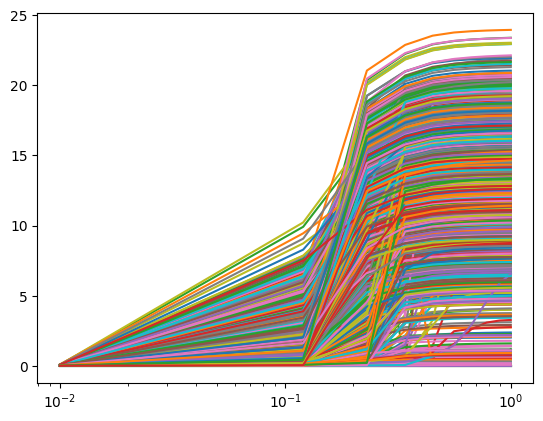

In [ ]:
# =========================
# Solving ODE system
# =========================

# Change DDR values to test prediction quality
# DDRvec = np.logspace(1e-3, 10, num=10)
DDRvec  = np.linspace(0.01, 1, num=10)
# DDRvec = [81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
# DDRvec = [89]

Tstart           = 0
Tfinish          = 50
numberOfPoints   = 10
tspan            = np.linspace(Tstart, Tfinish, num=numberOfPoints)

plt.figure()

# Result containers
p53s15DR_df = pd.DataFrame(columns=[f"DDR_{DDRval:.3f}" for DDRval in DDRvec])
p53s46DR_df = pd.DataFrame(columns=[f"DDR_{DDRval:.3f}" for DDRval in DDRvec])

# -------------------------
# Patient loop
# -------------------------
for i in range(len(NB_params)):
    setpatientparams(i)

    p53s15DR = []
    p53s46DR = []

    # -------------------------
    # DDR sweep
    # -------------------------
    for DDRval in DDRvec:
        DDR = DDRval  # used by f(x, t) via global
        cons = scipy.integrate.odeint(f, x0, tspan)

        # take terminal values for p53s15 (index 4) and p53s46 (index 5)
        p53s15DR.append(cons[-1, 4])
        p53s46DR.append(cons[-1, 5])

        print(DDRval)

    # quick per-patient curve (p53s46 vs DDR)
    plt.plot(DDRvec, p53s46DR)

    # store per-patient dose response
    p53s15DR_df.loc[i] = p53s15DR
    p53s46DR_df.loc[i] = p53s46DR

    print(f"{round(i / len(NB_params), 2) * 100}%")

# winsound.PlaySound(directory + '/#dev/situation_log_updated.wav', winsound.SND_FILENAME)

plt.xscale('log')
plt.show()

# Optional: save results
# p53s15DR_df.to_csv('p53s15DR_tp53.csv', index=False)
# p53s46DR_df.to_csv('p53s46DR_tp53.csv', index=False)

In [ ]:
p53s15DR_df['CellLine_ID'] = NB_params["CellLine_ID"]
# p53s15DR_df['PATIENT_ID'] = NB_params['PATIENT_ID']

p53s46DR_df['CellLine_ID'] = NB_params["CellLine_ID"]
# p53s46DR_df['PATIENT_ID'] = NB_params['PATIENT_ID']

p53s15DR_df.to_csv('p53s15DR_tp53_2_new.csv', index=False)
p53s46DR_df.to_csv('p53s46DR_tp53_2_new.csv', index=False)

In [ ]:
p53s15DR_df.to_csv('./p53s15DR_tp53_2.csv', index=False)
p53s46DR_df.to_csv('./p53s46DR_tp53_2.csv', index=False)

In [18]:
NB_params.head(1)

,CellLine_ID,HIPK2,WSB1,MDM2,TP53,ATM,PPM1D,CHEK2,SIAH1
0,ACH-001113,4.509898,5.997769,5.334618,4.8769,4.883005,3.529846,4.448273,5.375922


**End of the Notebook**